## Pricing Options by Monte Carlo Simulation

Pricing European Call Options using Monte Carlo simulations and comparing it to the option price determined by the Black Scholes Model.

Also comparing both of them to the option price valuated in real life

In [ ]:
 #Importing necessary libraries
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import yfinance as yf
from scipy.stats import norm

: 

## Option Pricing By Black Scholes

The Black-Scholes model assumes that the stock price follows a geometric Brownian motion (with risk neutral pricing and no arbitrage):

$$dS_t = rS_tdt + \sigma S_tdW_t$$

where:
- $S_t$ is the stock price at time $t$
- $r$ is the risk-free rate
- $\sigma$ is the volatility
- $W_t$ is a Weiner pocess/ standard Brownian motion

Upon solving this Differential Equation (using Itô's lemma), we get:

$$C(S_0, K, T) = S_0\Phi(d_1) - Ke^{-rT}\Phi(d_2)$$

where:
$$d_1 = \frac{\ln(S_0/K) + (r + \sigma^2/2)T}{\sigma\sqrt{T}}$$
$$d_2 = d_1 - \sigma\sqrt{T}$$
and $\Phi$ is the standard normal CDF.


In [ ]:
def BlackScholesPricing(S0,K,T,r,sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)


## Option Pricing By Monte Carlo Simulation

The fundamental theorem of asset pricing states that in the absence of arbitrage, there exists a risk-neutral measure Q, under which the discounted price process is a martingale (expected future payoff = current payoff). For a European call option with strike $K$ and maturity $T$, the price is:

$$C(S_0, K, T) = e^{-rT}E^{Q}[\max(S_T - K, 0)]$$

Rather than solving the Black Scholes DE, we could price options using Monte Carlo simulation by directly approximating the risk-neutral expectation:

$$C(S_0, K, T) = e^{-rT}E^{Q}[\max(S_T - K, 0)]$$

Under the risk-neutral measure, the terminal stock price $S_T$ follows a lognormal distribution (log ($S_T$) is normally distributed):

$$S_T = S_0\exp((r-\frac{1}{2}\sigma^2)T + \sigma\sqrt{T}Z)$$ 

where $Z \sim N(0,1)$ (standard normal distribution)

The Monte Carlo method involves:
1. Generate n independent draws $Z_i \sim N(0,1)$
2. Calculate terminal prices $S_T^i$ using the formula above
3. Calculate option payoffs $\max(S_T^i - K, 0)$
4. Average and discount: $\frac{e^{-rT}}{n}\sum_{i=1}^n \max(S_T^i - K, 0)$


In [ ]:
def MonteCarloPricing(S0,K,T,r,sigma,n_simulations=1000000):
    np.random.seed(42)
    Z = np.random.standard_normal(n_simulations)
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * (T**0.5) * Z)
    payoffs = np.maximum(ST - K, 0)
    disc_payoff=np.exp(-r * T) *payoffs
    return disc_payoff
    

## Getting the Actual Option Price at 2025-06-03

In [153]:
stock = yf.Ticker('AAPL')
option_chain = stock.option_chain("2025-06-06")
calls=pd.DataFrame(option_chain.calls)
calls['lastTradeDate'] = pd.to_datetime(calls['lastTradeDate'])

exp = calls[calls['lastTradeDate'].dt.date == pd.to_datetime('2025-06-03').date()] # Filtering rows where the date part matches 2025-06-03
strikes=exp['strike'].to_numpy()
irl_strike=np.mean(strikes)
# print(exp)
irl_strike

193.42857142857142

In [172]:
# Fetching AAPL price data for 2024-2025 period
ticker = "AAPL"
start_date = "2024-06-02"
end_date = "2025-06-03"
data = pd.DataFrame(yf.download(ticker, start=start_date, end=end_date))
close_prices=data['Close']

# Calculating volatility and returns
returns = np.log(close_prices / close_prices.shift(1)).dropna()  #Assuming stock prices follow a lognormal distribution
volatility = float(np.std(returns) * np.sqrt(252))  # Annualized
print(np.mean(returns))
print(volatility)

[*********************100%***********************]  1 of 1 completed

0.00017443589582776605
0.3288382973950468



C:\Users\shand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
C:\Users\shand\AppData\Local\Temp\ipykernel_23840\828320127.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volatility = float(np.std(returns) * np.sqrt(252))  # Annualized


To get the risk free rate, I am using the Market Yield on U.S. Treasury Securities at 1-Year Constant Maturity

In [131]:
US_Treasury_Rates = pd.DataFrame(web.DataReader('DGS1', 'fred', start_date, '2024-07-02')) # Gives the daily yield on U.S. Treasury securities with a 1-year maturity

rf_rates = US_Treasury_Rates['DGS1'].to_numpy()
rf_rates=rf_rates[~np.isnan(rf_rates)]
rf_rate=np.mean(rf_rates)
print(rf_rate)  


5.108095238095237


In [173]:
# Step 3: Set option parameters
S0 = float(data.loc["2024-06-03"]["Close"] )   # First closing price
K = S0           # Strike Price (At the money option for simplicity)
T = 1            # Maturity Period (in years)
r = rf_rate       # Risk Free Rate
sigma = volatility # Volatility
n_simulations = 10000000  # Number of simulations
 
disc_payoff= MonteCarloPricing(S0,K,T,r,sigma,n_simulations)  
mc_price=np.mean(disc_payoff)  # Option price determined by Monte Carlo
bs_price =BlackScholesPricing(S0,K,T,r,sigma) # Option price determined by Monte Carlo

print(f"Estimated Annual Volatility: {round(sigma, 4)}")
print(f"Monte Carlo Price (European Call): {round(mc_price, 4)} $")
print(f"Black-Scholes Price (European Call): {round(bs_price, 4)} $")
print(f"Real Life Price (European Call): {round(irl_strike, 4)} $")

print(f"Deviation of Monte Carlo Option Pricing from that determined by Black Scholes: {abs(bs_price-mc_price)*100/bs_price} %")
print(f"Deviation of Monte Carlo Option Pricing from real life strike price: {abs(mc_price-irl_strike)*100/irl_strike} %")

C:\Users\shand\AppData\Local\Temp\ipykernel_23840\3603134147.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(data.loc["2024-06-03"]["Close"] )   # First closing price


Estimated Annual Volatility: 0.3288
Monte Carlo Price (European Call): 191.955 $
Black-Scholes Price (European Call): 191.9588 $
Real Life Price (European Call): 193.4286 $
Deviation of Monte Carlo Option Pricing from that determined by Black Scholes: 0.0020115741505728267 %
Deviation of Monte Carlo Option Pricing from real life strike price: 0.7618312936595851 %


We see that analytically solving Black Scholes and Monte Carlo Simulation led us  approximately to the same value (which wasnt that far off from the real strike price as well)

This was obvious since by the Law of Large Numbers (as sampling tends to $\infty$, sampled mean should converge to true mean):

$$ \lim_{n \to \infty} \frac{1}{n}\sum_{i=1}^n \max(S_T^i - K, 0) \xrightarrow{}E^{Q}[\max(S_T - K, 0)]$$




Plotting all the simulated option prices

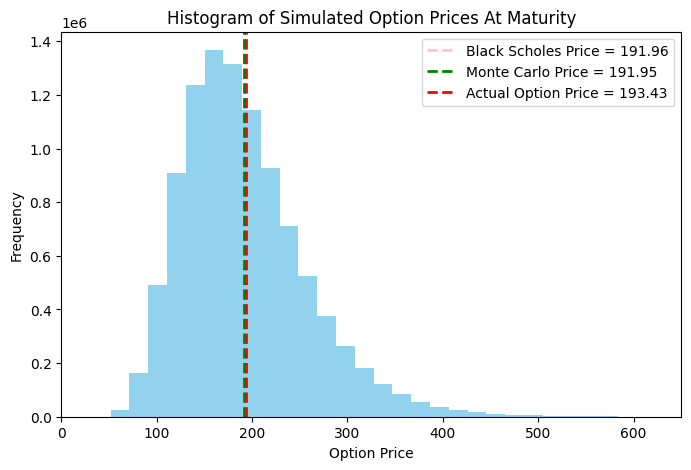

In [171]:
plt.figure(figsize=(8,5))
plt.hist(disc_payoff, bins=50, color='skyblue', alpha=0.9)
plt.title("Histogram of Simulated Option Prices At Maturity")
plt.axvline(x=bs_price, color='pink', linestyle='--', linewidth=2, label=f'Black Scholes Price = {bs_price:.2f}')
plt.axvline(x=mc_price, color='green', linestyle='--', linewidth=2, label=f'Monte Carlo Price = {mc_price:.2f}')
plt.axvline(x=irl_strike, color='red', linestyle='--', linewidth=2, label=f'Actual Option Price = {irl_strike:.2f}')
plt.xlim(0, 650)  
plt.xlabel("Option Price")
plt.ylabel("Frequency")
plt.legend()
plt.grid(False)
plt.show()
